Some code is taken from: https://neptune.ai/blog/select-model-for-time-series-prediction-task and https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [53]:
df = pd.read_csv("https://raw.githubusercontent.com/kaebry/DSF/main/Data/daily_data.csv")

In [54]:
# Set datetime as index
df.rename(columns={"Unnamed: 0": "datetime"}, inplace = True)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
#drop first row
df.drop("2012-01-01", inplace=True)

In [55]:
df.columns

Index(['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point', 'water_level',
       'inflow_linth (m3/s)', 'outflow_limmat (m3/s)', 'precipitation (mm)',
       'change_rate', 'Evapotranspiration (mm)'],
      dtype='object')

# **Decomposition**

<AxesSubplot: xlabel='datetime'>

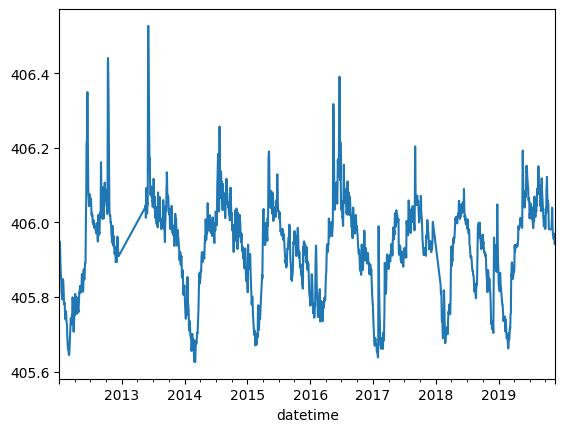

In [56]:
df["water_level"].plot()

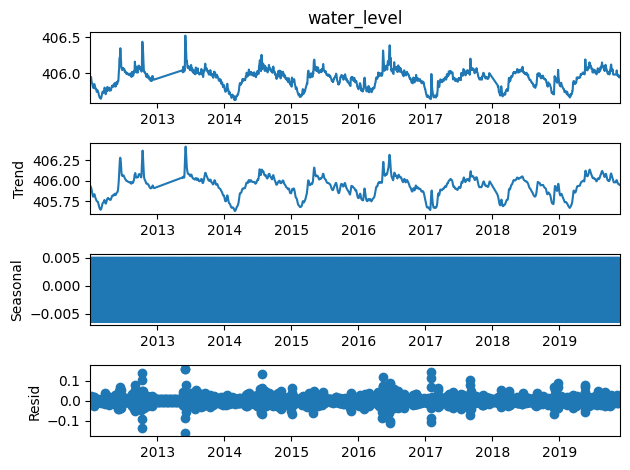

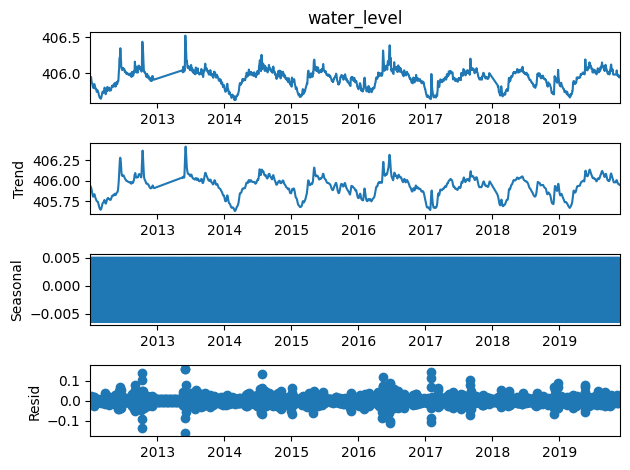

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["water_level"])
result.plot()

# **Autocorrelation**


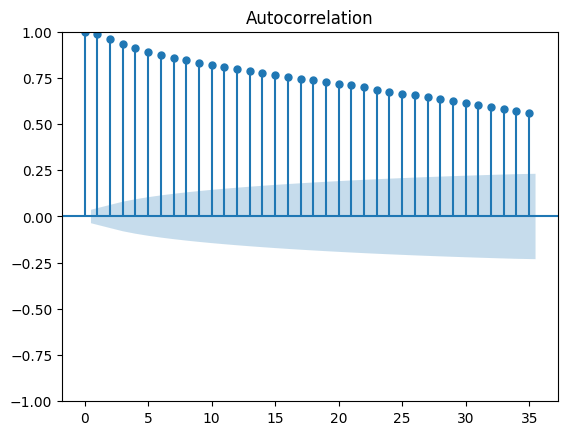

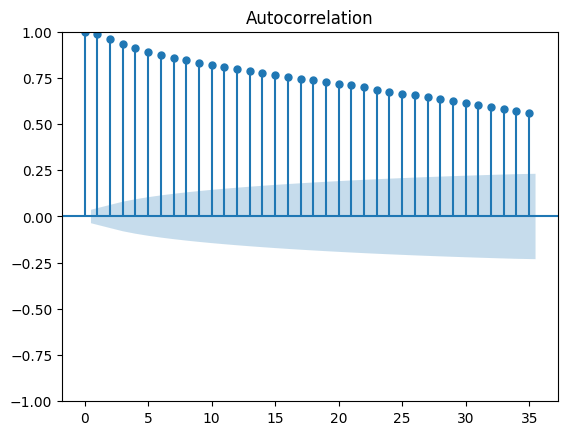

In [58]:
#ACF x axis represents the number of "lag", the higher the autocorrelation the more it correlates with present value

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["water_level"])

C:\Users\kaeli\miniconda3\envs\ProjectDSF\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


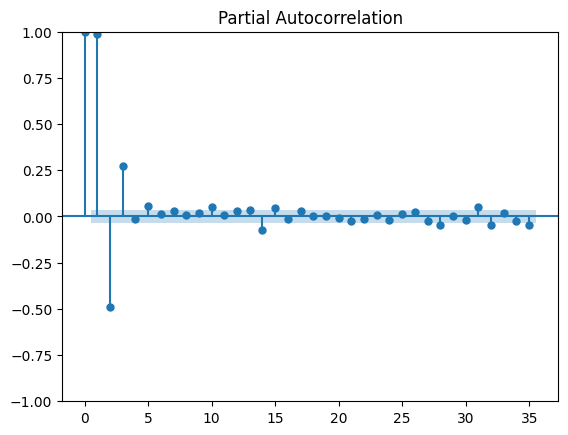

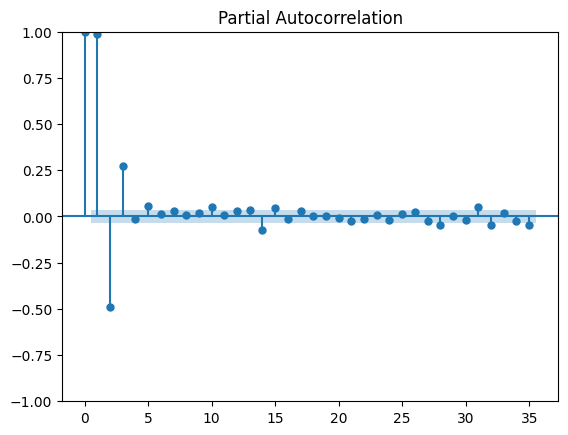

In [ ]:
#PACF (partial autocorrelation) list only additional auto correlation

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["water_level"])

# **Stationarity**

In [ ]:
#Stationarity time series are time series without trends
#Dickey-Fuller test to show if non-stationarity

from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df["water_level"].values, autolag='AIC')
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

#p-values <0.05 ---> No trend
#https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ "test statistic is lower than the critical value shown, time series is stationary"


ADF test statistic: -4.341769209510918
ADF p-values: 0.0003757721803144856
ADF number of lags used: 14
ADF number of observations: 2872
ADF critical values: {'1%': -3.4326289534601844, '5%': -2.862546886869174, '10%': -2.5673059951476556}
ADF best information criterion: -15096.378524213196


In [ ]:
# Differencing?
'''
prev_co2_value = co2_data.co2.shift()
differenced_co2 = co2_data.co2 - prev_co2_value
differenced_co2.plot()
'''

'\nprev_co2_value = co2_data.co2.shift()\ndifferenced_co2 = co2_data.co2 - prev_co2_value\ndifferenced_co2.plot()\n'

# **VAR**

In [66]:
import statsmodels.api as sm

df.columns

Index(['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point', 'water_level',
       'inflow_linth (m3/s)', 'outflow_limmat (m3/s)', 'precipitation (mm)',
       'change_rate', 'Evapotranspiration (mm)'],
      dtype='object')

In [69]:
#Granger's causality test if value <0.05 past value x causes serie y

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,suction_tension (20cm)_x,suction_tension (40cm)_x,suction_tension (70cm)_x,water_temperature_x,barometric_pressure_qfe_x,dew_point_x,water_level_x,inflow_linth (m3/s)_x,outflow_limmat (m3/s)_x,precipitation (mm)_x,change_rate_x,Evapotranspiration (mm)_x
suction_tension (20cm)_y,1.0000,0.0000,0.0014,0.0000,0.0000,0.0202,0.0400,0.1355,0.1624,0.0,0.2790,0.0
suction_tension (40cm)_y,0.0000,1.0000,0.0000,0.0002,0.0000,0.0088,0.0086,0.0121,0.0017,0.0,0.0692,0.0
suction_tension (70cm)_y,0.0000,0.0000,1.0000,0.0014,0.0039,0.0402,0.2150,0.2328,0.0464,0.0,0.0184,0.0
water_temperature_y,0.0000,0.0232,0.8078,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0659,0.0
barometric_pressure_qfe_y,0.0583,0.2187,0.5256,0.0345,1.0000,0.0240,0.6818,0.3096,0.3705,0.0,0.0005,0.0
dew_point_y,0.0000,0.0000,0.0044,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0
water_level_y,0.0441,0.0765,0.6263,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0,0.0000,0.0
inflow_linth (m3/s)_y,0.0000,0.0002,0.1334,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0,0.0000,0.0
outflow_limmat (m3/s)_y,0.0000,0.0000,0.0511,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0,0.0000,0.0
precipitation (mm)_y,0.0000,0.0000,0.1831,0.0000,0.0000,0.0000,0.0002,0.0002,0.0253,1.0,0.0001,0.0


In [70]:
#Cointegration test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  2351.19   > 311.1288  =>   True
suction_tension (40cm) ::  1708.17   > 263.2603  =>   True
suction_tension (70cm) ::  1301.8    > 219.4051  =>   True
water_temperature ::  970.1     > 179.5199  =>   True
barometric_pressure_qfe ::  714.04    > 143.6691  =>   True
dew_point ::  545.03    > 111.7797  =>   True
water_level ::  392.88    > 83.9383   =>   True
inflow_linth (m3/s) ::  254.32    > 60.0627   =>   True
outflow_limmat (m3/s) ::  152.96    > 40.1749   =>   True
precipitation (mm) ::  65.84     > 24.2761   =>   True
change_rate ::  19.99     > 12.3212   =>   True
Evapotranspiration (mm) ::  0.02      > 4.1296    =>   False


In [73]:
nobs = 600
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(2287, 12)
(600, 12)


In [76]:
#Check stationarity for all series

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [75]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

C:\Users\kaeli\AppData\Local\Temp\ipykernel_17504\860807690.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_train.iteritems():


    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0328
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6762
 No. Lags Chosen       = 10
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has u

In [78]:
from statsmodels.tsa.api import VAR

In [79]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -28.326003291057138
BIC :  -27.934668566770462
FPE :  4.990840783017059e-13
HQIC:  -28.18328329280914 

Lag Order = 2
AIC :  -29.569196827428346
BIC :  -28.81635814427802
FPE :  1.4396785501348354e-13
HQIC:  -29.29463003246505 

Lag Order = 3
AIC :  -29.68709639366626
BIC :  -28.57249240705308
FPE :  1.2795952674556687e-13
HQIC:  -29.280581626970484 

Lag Order = 4
AIC :  -29.706378811212
BIC :  -28.229747869398807
FPE :  1.2552145531628352e-13
HQIC:  -29.167814775413586 

Lag Order = 5
AIC :  -29.75131842613905
BIC :  -27.912398569754775
FPE :  1.2001429222426686e-13
HQIC:  -29.080603701313663 

Lag Order = 6
AIC :  -29.76306270516561
BIC :  -27.5615916667083
FPE :  1.1862604678551577e-13
HQIC:  -28.960095748633158 

Lag Order = 7
AIC :  -29.731292107773093
BIC :  -27.16700731111193
FPE :  1.2247404745547296e-13
HQIC:  -28.795971253895683 

Lag Order = 8
AIC :  -29.738294129806963
BIC :  -26.810932689683234
FPE :  1.2164412526981934e-13
HQIC:  -28.670517589786463 

C:\Users\kaeli\miniconda3\envs\ProjectDSF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [80]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.24,11.27,7.589e+04,11.25
1,-28.30,-27.90,5.137e-13,-28.15
2,-29.54,-28.79*,1.476e-13,-29.27*
3,-29.67,-28.55,1.307e-13,-29.26
4,-29.68,-28.20,1.289e-13,-29.14
5,-29.72,-27.88,1.235e-13,-29.05
6,-29.74*,-27.53,1.215e-13*,-28.93
7,-29.71,-27.14,1.250e-13,-28.77
8,-29.72,-26.79,1.238e-13,-28.65
9,-29.70,-26.41,1.265e-13,-28.50


In [81]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Nov, 2022
Time:                     16:20:56
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -27.9347
Nobs:                     2286.00    HQIC:                  -28.1833
Log likelihood:          -6391.70    FPE:                4.99084e-13
AIC:                     -28.3260    Det(Omega_mle):     4.66252e-13
--------------------------------------------------------------------
Results for equation suction_tension (20cm)
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                          -1147.956681       562.230602           -2.042           0.041
L1.suction_tension (20cm)          0.929230         0.009749           95.311        

# **Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

In [87]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

suction_tension (20cm) : 1.71
suction_tension (40cm) : 1.76
suction_tension (70cm) : 2.22
water_temperature : 1.61
barometric_pressure_qfe : 1.5
dew_point : 1.68
water_level : 1.71
inflow_linth (m3/s) : 1.09
outflow_limmat (m3/s) : 1.87
precipitation (mm) : 1.98
change_rate : 1.71
Evapotranspiration (mm) : 2.01


In [117]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 1

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

1


array([[5.35833333e+00, 3.85000000e+00, 1.97291667e+00, 6.67500000e+00,
        9.69951389e+02, 2.71736111e+00, 4.05900069e+02, 3.97393333e+01,
        7.65300417e+01, 0.00000000e+00, 1.69379534e-05, 2.94000000e+00]])

In [116]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_forecast')
df_forecast

,suction_tension (20cm)_forecast,suction_tension (40cm)_forecast,suction_tension (70cm)_forecast,water_temperature_forecast,barometric_pressure_qfe_forecast,dew_point_forecast,water_level_forecast,inflow_linth (m3/s)_forecast,outflow_limmat (m3/s)_forecast,precipitation (mm)_forecast,change_rate_forecast,Evapotranspiration (mm)_forecast
datetime,,,,,,,,,,,,
2018-04-07,7.993189,4.586861,2.172587,7.185468,968.711835,3.510939,405.900077,39.337680,76.458666,0.941735,2.378439e-08,2.048021
2018-04-08,9.220377,4.980484,2.316730,7.536271,968.028926,3.869153,405.899632,38.938082,77.302901,1.682151,-1.091159e-06,1.468945
2018-04-09,9.659673,5.177390,2.428918,7.780107,967.708333,3.953479,405.900240,38.832719,79.111288,2.071603,1.504507e-06,1.107381
2018-04-10,9.697682,5.271739,2.526160,7.953490,967.600391,3.892540,405.901574,38.981592,81.343635,2.232479,3.288599e-06,0.889451
2018-04-11,9.548379,5.312509,2.615593,8.080360,967.610476,3.769680,405.903003,39.267470,83.540571,2.275393,3.522451e-06,0.762646
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-23,9.723260,5.487310,3.486721,13.064907,969.174907,6.725127,405.932718,53.011358,96.837068,2.550516,9.305938e-10,1.319720
2019-11-24,9.723247,5.487289,3.486706,13.064876,969.174892,6.725109,405.932718,53.011512,96.837289,2.550516,9.591108e-10,1.319720
2019-11-25,9.723235,5.487268,3.486691,13.064845,969.174877,6.725091,405.932718,53.011664,96.837509,2.550516,9.870260e-10,1.319720


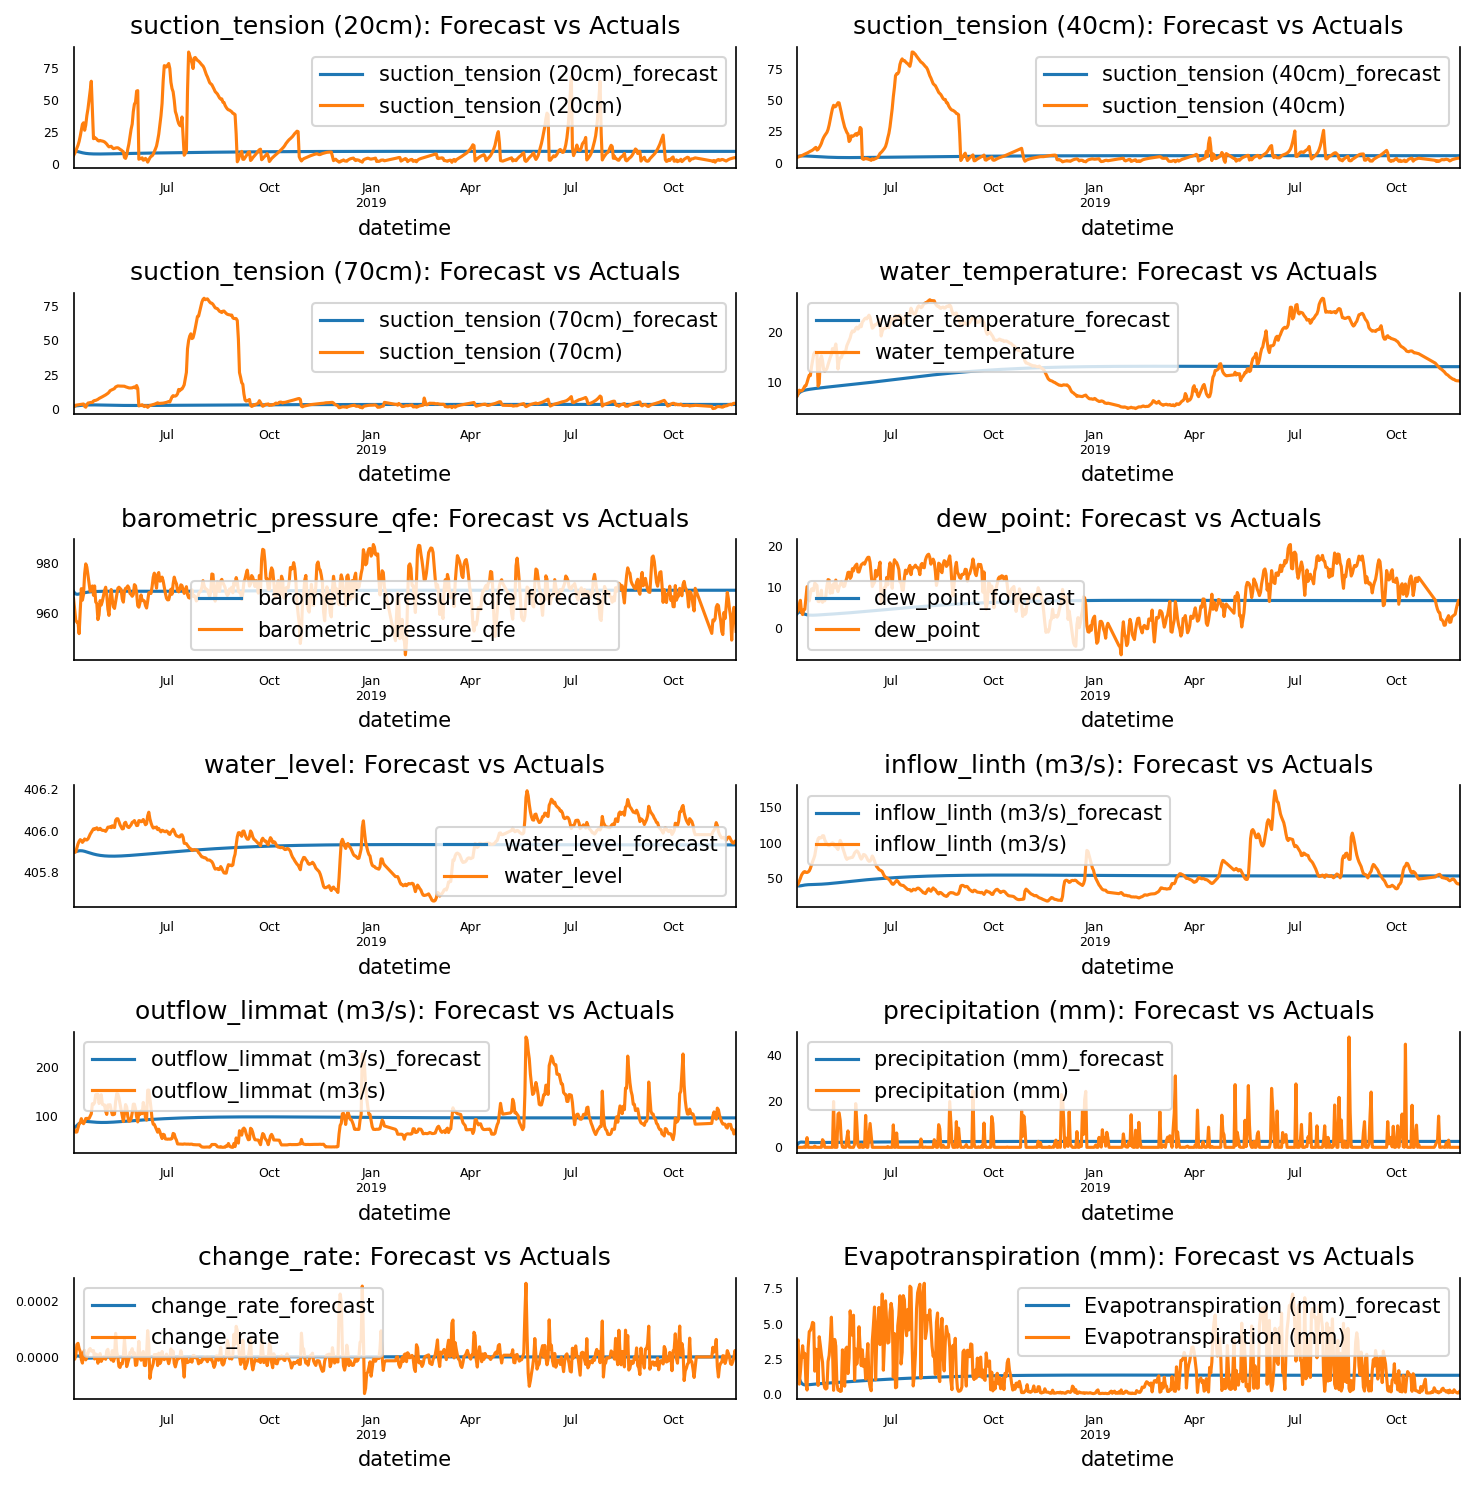

In [110]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [115]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

for t in df_test.columns:
    print(f'Forecast Accuracy of: {t}')
    accuracy_prod = forecast_accuracy(df_forecast[t+'_forecast'].values, df_test[t])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))



Forecast Accuracy of: suction_tension (20cm)
mape :  1.2263
me :  -5.0489
mae :  11.5486
mpe :  0.8272
rmse :  19.8647
corr :  -0.4425
minmax :  0.5364
Forecast Accuracy of: suction_tension (40cm)
mape :  1.1198
me :  -7.2709
mae :  10.2986
mpe :  0.6663
rmse :  21.6566
corr :  -0.6117
minmax :  0.5065
Forecast Accuracy of: suction_tension (70cm)
mape :  0.4545
me :  -6.4702
mae :  7.188
mpe :  -0.0754
rmse :  18.8121
corr :  -0.4029
minmax :  0.3691
Forecast Accuracy of: water_temperature
mape :  0.5237
me :  -3.3867
mae :  6.8878
mpe :  0.0412
rmse :  7.959
corr :  -0.2377
minmax :  0.3748
Forecast Accuracy of: barometric_pressure_qfe
mape :  0.0054
me :  0.1357
mae :  5.1846
mpe :  0.0002
rmse :  7.0281
corr :  0.0589
minmax :  0.0053
Forecast Accuracy of: dew_point
mape :  2.3538
me :  -2.5533
mae :  5.8468
mpe :  -0.0297
rmse :  6.7071
corr :  -0.2971
minmax :  0.5632
Forecast Accuracy of: water_level
mape :  0.0002
me :  -0.0197
mae :  0.0993
mpe :  -0.0
rmse :  0.118
corr :  -0.

C:\Users\kaeli\AppData\Local\Temp\ipykernel_17504\3834880106.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\kaeli\AppData\Local\Temp\ipykernel_17504\3834880106.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\kaeli\AppData\Local\Temp\ipykernel_17504\3834880106.py:13: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax
